# Setup and Import

In [1]:
import mailbox
import email

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
import nltk.sentiment as sentiment                          #from nltk.sentiment import SentimentIntensityAnalyzer

# import gensim
import gensim.parsing.preprocessing as gs_preprocessing     #from gensim.parsing.preprocessing import *
import gensim.corpora as corpora
import gensim.models as models                              #from gensim.models import Word2Vec,LdaMulticore  #from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# import sklearn
import sklearn.feature_extraction.text as text              #from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as model_selection           #from sklearn.model_selection import RandomizedSearchCV, train_test_split
import sklearn.preprocessing as sk_preprocessing            #from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics                           #from sklearn.metrics import accuracy_score, precision_score, recall_score
import sklearn.svm as svm                                   #from sklearn.svm import SVC

import tensorflow.config as tf_config                       #from tensorflow import config
import tensorflow.keras as tf_keras                         #from tensorflow import keras

import numpy as np
import pandas as pd
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Data preprocessing

## Load and Explore Data

### Functions: Extract email from .mbox file and .eml file


In [2]:
def extract_emails_from_mbox(mbox_file_name):
  messages=[]
  try:
    mbox = mailbox.mbox(mbox_file_name)
    for message in mbox:
      messages.append(message)
    # messages = [m[1] for m in mbox.items()]
  except FileNotFoundError:
    print(f"File not found: {mbox_file_name}")
  return messages


def extract_email_from_eml(eml_file_name):
  email_message=None
  try:
      with open(eml_file_name, "r") as email_file:
          email_message = email.message_from_file(email_file)
  except FileNotFoundError:
      print(f"File not found: {eml_file_name}")
  except Exception as e:
      print(f"An error occurred: {e}")
  return email_message

#From:https://stackoverflow.com/questions/7166922/extracting-the-body-of-an-email-from-mbox-file-decoding-it-to-plain-text-regard

### Functions: Extract component of email

In [3]:
def extract_sender_email(email_message):
  return email_message.get("From")


def extract_subject_email(email_message):
  return email_message.get("Subject")


def extract_content_email(email_message):
  body = None
  if(email_message.is_multipart()):
    for part in email_message.walk():
      if(part.is_multipart()):
        for subpart in part.walk():
          if(subpart.get_content_type() == "text/plain"):
            body = subpart.get_payload(decode=True)
          # elif(subpart.get_content_type() == "text/html"):
          #   body = subpart.get_payload(decode=True)
      elif(part.get_content_type() == "text/plain"):
        body = part.get_payload(decode=True)
  else:
    body = email_message.get_payload(decode=True)
  if(body is not None) and isinstance(body, bytes):
    #chuyển dữ liệu dạng byte string sang string (utf-8)
    try:
      body=body.decode('utf-8', errors='ignore')
    except UnicodeDecodeError:
      # Không làm gì cả nếu lỗi xảy ra, giữ nguyên giá trị body
      pass
  return body

### Process: Extract phishing emails

In [15]:
phishing_message_bodies = []

phishing_messages = extract_emails_from_mbox("/content/fradulent_emails.txt")
for message in phishing_messages:
  body=extract_content_email(message)
  if (body is not None and body.strip()):
    phishing_message_bodies.append(body)
    #print(body)
    #print(body).decode('utf-8')

print(len(phishing_message_bodies))
print(len(phishing_messages))

3928
3978


### Process: Extract benign emails

In [18]:
benign_message_bodies = []

benign_messages = extract_emails_from_mbox("/content/emails-enron-legal-mails.mbox")
for message in benign_messages:
  body=extract_content_email(message)
  if (body is not None and body.strip()):
    benign_message_bodies.append(body)

print(len(benign_message_bodies))
print(len(benign_messages))

4279
4279


### ===TEST===

In [ ]:
msg = extract_email_from_eml("/content/sample1.eml")
messages = extract_emails_from_mbox("/emails-enron-legal-mails.mbox")
if(msg):
  print(extract_sender_email(msg))
  print(extract_subject_email(msg))
  print(extract_content_email(msg))

File not found: /content/sample1.eml


In [ ]:
print(phishing_messages[0])
print(phishing_message_bodies[0])

In [19]:
print(benign_messages[0])
print(benign_message_bodies[0])

Message-ID: <27151276.1075857703081.JavaMail.evans@thyme>
Date: Thu, 28 Dec 2000 16:37:00 -0800 (PST)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Lavorato, John </o=ENRON/ou=NA/cn=Recipients/cn=Jlavora>
X-cc: 
X-bcc: 
X-Folder: \jlavora\COMP
X-Origin: Lavorado-J
X-FileName: jlavora.pst

?	Pay well ? and pay for performance (with bonuses based on merit, not entitlement).




Just a soundbite from a PRC email.  I am getting worried about Mike G. and myself.  Are you open to more discussions?

Phillip


?	Pay well ? and pay for performance (with bonuses based on merit, not entitlement).




Just a soundbite from a PRC email.  I am getting worried about Mike G. and myself.  Are you open to more discussions?

Phillip




## Simple preprocessing

### Custom stop words and preprocessing filters

In [11]:
# Custom stop words and preprocessing filters
stopWords = nltk.corpus.stopwords
stopWords = stopWords.words("english")
stopWords.extend(["nbsp", "font", "sans", "serif", "bold", "arial", "verdana", "helvetica", "http", "https", "www", "html", "enron", "margin", "spamassassin"])

def remove_custom_stopwords(p):
    return gs_preprocessing.remove_stopwords(p, stopwords=stopWords)

CUSTOM_FILTERS = [lambda x: x.lower(), gs_preprocessing.strip_tags, gs_preprocessing.strip_punctuation,
                  gs_preprocessing.strip_multiple_whitespaces, gs_preprocessing.strip_numeric, remove_custom_stopwords,
                  gs_preprocessing.remove_stopwords, gs_preprocessing.strip_short, gs_preprocessing.stem_text]


In [12]:
def custom_preprocessing(messages):
  preprocessed_messages = []
  for message in messages:
    preprocessed = gs_preprocessing.preprocess_string(message,filters = CUSTOM_FILTERS)
    #NEED FIX: xu ly trung lap chi can thiet o black list
    # if preprocessed and (preprocessed not in preprocessed_messages):
    #   preprocessed_messages.append(preprocessed)
    preprocessed_messages.append(preprocessed)

  return preprocessed_messages

#Bỏ các phần tử rỗng và trùng lập
def duplicate_filter(texts):
    unique_texts = []
    for text in texts:
        if text and (text not in unique_texts):
            unique_texts.append(text)
    return unique_texts


### Preprocess messages

In [16]:
#preprocessing phishing message bodies
phishing_preprocessed = []
phishing_preprocessed =  custom_preprocessing(phishing_message_bodies)

print(len(phishing_preprocessed))

3928


In [20]:
#preprocessing benign message bodies
benign_preprocessed = []
benign_preprocessed =  custom_preprocessing(benign_message_bodies)

print(len(benign_preprocessed))

4279


### ===TEST===

In [21]:
#Test
print(len(phishing_message_bodies))
print(len(duplicate_filter(phishing_message_bodies)))
print(len(phishing_preprocessed))
print(len(duplicate_filter(phishing_preprocessed)))

print(phishing_preprocessed[0])

3928
3289
3928
3178
['jame', 'ngola', 'confidenti', 'tel', 'mail', 'jame', 'ngola', 'maktoob', 'com', 'urgent', 'busi', 'assist', 'partnership', 'dear', 'friend', 'jame', 'ngola', 'person', 'assist', 'late', 'congoles', 'presid', 'laurent', 'kabila', 'assassin', 'bodi', 'guard', 'jan', 'incid', 'occur', 'presenc', 'hold', 'meet', 'excel', 'financi', 'return', 'diamond', 'sale', 'area', 'control', 'democrat', 'republ', 'congo', 'forc', 'foreign', 'alli', 'angola', 'zimbabw', 'receiv', 'previou', 'dai', 'usd', 'million', 'unit', 'state', 'dollar', 'cash', 'diplomat', 'box', 'rout', 'zimbabw', 'purpos', 'write', 'letter', 'solicit', 'assist', 'cover', 'fund', 'collabor', 'move', 'said', 'fund', 'bank', 'account', 'sum', 'usd', 'million', 'unit', 'state', 'dollar', 'deposit', 'secur', 'compani', 'ghana', 'diplomat', 'box', 'gold', 'worth', 'usd', 'million', 'unit', 'state', 'dollar', 'safe', 'keep', 'secur', 'vault', 'invest', 'countri', 'introduc', 'reliabl', 'friend', 'travel', 'member',

# Feature Engineering

In [22]:
all_message_preprocessed = phishing_preprocessed + benign_preprocessed
all_message_bodies = phishing_message_bodies + benign_message_bodies

print(len(all_message_preprocessed))
print(len(all_message_bodies))

8207
8207


## Word2Vec Embedding


In [ ]:
# Train the model on all messages
word2vec_model = models.Word2Vec(all_message_preprocessed, vector_size=100, min_count=1, workers=3, window=5)
#From: https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

In [ ]:
word2vec_model.wv.most_similar("dollar", topn=20)

[('billion', 0.9507895112037659),
 ('win', 0.9110546112060547),
 ('ubid', 0.903036892414093),
 ('maximum', 0.8959468603134155),
 ('tend', 0.8940055966377258),
 ('quantiti', 0.8918537497520447),
 ('supersit', 0.8888633251190186),
 ('defici', 0.8846665024757385),
 ('prioriti', 0.8796712160110474),
 ('half', 0.8794583082199097),
 ('auction', 0.8794552087783813),
 ('size', 0.8770312666893005),
 ('dissent', 0.8762837648391724),
 ('entri', 0.8752008080482483),
 ('dcq', 0.8745139837265015),
 ('store', 0.8734740018844604),
 ('majeur', 0.8722878098487854),
 ('grab', 0.8720036149024963),
 ('shorter', 0.8716081380844116),
 ('furthermor', 0.8704047203063965)]

In [ ]:
word2vec_model.wv["dollar"]

## LDA Topic Modeling

### Init the number of topics

In [23]:
numTopics = 1024

### Create dictionary and corpus

In [24]:
dictionary = corpora.Dictionary(all_message_preprocessed)
corpus = [dictionary.doc2bow(text) for text in all_message_preprocessed]

In [25]:
#test
iterator = iter(dictionary.items())
print([next(iterator) for _ in range(6)])
print(corpus[0])

[(0, 'accept'), (1, 'account'), (2, 'advic'), (3, 'alli'), (4, 'angola'), (5, 'area')]
[(0, 1), (1, 5), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 5), (9, 1), (10, 2), (11, 1), (12, 1), (13, 4), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 2), (44, 3), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 2), (62, 4), (63, 1), (64, 3), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 3), (76, 1), (77, 4), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 2), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 2), (97, 2), (98, 1), (99, 3), (100, 4), (101, 4), (1

###  Create LDA model

In [26]:
LDA_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=numTopics)

In [27]:
#Test
# Print keyword for the topics
print(LDA_model.print_topics())

[(121, '0.032*"com" + 0.010*"servic" + 0.009*"oe" + 0.008*"dai" + 0.008*"local" + 0.008*"engin" + 0.007*"state" + 0.006*"updat" + 0.006*"gift" + 0.006*"email"'), (625, '0.070*"impact" + 0.050*"mail" + 0.030*"prioriti" + 0.023*"com" + 0.022*"asp" + 0.012*"hotmail" + 0.009*"line" + 0.008*"msn" + 0.006*"bank" + 0.006*"permiss"'), (988, '0.078*"abel" + 0.043*"decemb" + 0.022*"franklin" + 0.021*"georg" + 0.021*"patrick" + 0.018*"stori" + 0.017*"ect" + 0.015*"johnson" + 0.015*"maria" + 0.013*"desk"'), (259, '0.028*"press" + 0.016*"com" + 0.013*"heat" + 0.008*"agreement" + 0.006*"review" + 0.005*"gener" + 0.005*"meet" + 0.005*"allegedli" + 0.005*"dai" + 0.005*"toni"'), (792, '0.043*"phase" + 0.032*"electr" + 0.026*"convers" + 0.021*"make" + 0.018*"absenc" + 0.017*"built" + 0.017*"dam" + 0.016*"obvious" + 0.016*"span" + 0.015*"spot"'), (551, '0.150*"commission" + 0.045*"standard" + 0.028*"ga" + 0.025*"fed" + 0.019*"imbal" + 0.014*"extrem" + 0.014*"amend" + 0.013*"com" + 0.013*"notic" + 0.012*"

##Doc2Vec Embedding

In [28]:
tagged_data = [models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(all_message_preprocessed)]

In [29]:
#Khởi tạo và huấn luyện trực tiếp
doc2vec_model = models.Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4)

#Tách khởi tạo và huấn luyện1
# doc2vec_model = models.Doc2Vec(tagged_data, vector_size=100, min_count=1, epochs=10)
# doc2vec_model.build_vocab(tagged_data)
# doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

## Blacklist words

In [30]:
def get_file_lines(file_path):
  lines=[]
  try:
    with open(file_path, 'r') as file:
      for line in file:
        lines.append(line.strip())
  except FileNotFoundError:
    print(f"File not found: {file_path}")
  return lines

In [31]:
black_list_words = get_file_lines("/content/spam_wordlist.txt")
black_list = custom_preprocessing(black_list_words)
black_list = duplicate_filter(black_list)

print(len(black_list_words))
print(len(black_list))

582
369


## TF-IDF

In [32]:
#TF-IDF
max_term=6

In [34]:
def list_to_string(lst):
    return ' '.join(lst)

def count_all_upper_words(text):
    count = 0
    for word in text.split():
        if word.isupper():
            count += 1
    return count

In [35]:
tfidfVectorizer = text.TfidfVectorizer(max_features=max_term, preprocessor=list_to_string, sublinear_tf=True)
tfidf_matrix = tfidfVectorizer.fit_transform(all_message_preprocessed).toarray()

print(tfidfVectorizer.get_feature_names_out())
print(tfidf_matrix.shape)
print(tfidf_matrix[2])

['account' 'bank' 'com' 'ect' 'fund' 'monei']
(8207, 6)
[0.         0.         0.37148081 0.         0.54647204 0.75057998]


## Function: Create Vector

In [36]:
def create_vectors_from_messages(messages, messages_preprocessed, messages_corpus):
    # corpus = [dictionary.doc2bow(text) for text in messages_preprocessed] # Term document frequency
    all_vectors = []
    for i in range(len(messages)):
        topTopics = LDA_model.get_document_topics(messages_corpus[i], minimum_probability=0.0)

        # Can extend this array with other stuff later
        vec = [topTopics[i][1] for i in range(numTopics)] # Topics

        for v in doc2vec_model.infer_vector(messages_preprocessed[i]): # Doc2Vec
            vec.append(v)

        # Sentiment analysis of polarity
        sia = sentiment.SentimentIntensityAnalyzer()
        sentence = " ".join(messages_preprocessed[i])
        polarity = sia.polarity_scores(sentence)
        for s in polarity:
            vec.append(polarity[s])

        # Contains HTML
        if "<html>" in messages[i].lower():
            vec.append(1)
        else:
            vec.append(0)

        # Contains a link
        if "http://" in messages[i].lower() or "https://" in messages[i].lower():
            vec.append(1)
        else:
            vec.append(0)

        # How many blacklisted phrases/words appear in this email
        for b in black_list:
            count = 0
            for word in b:
                if word in messages_preprocessed[i]:
                    count += 1
            vec.append(count)

        # TF-IDF for top terms
        for word_weight in tfidf_matrix[i]:
            vec.append(word_weight)

        # Has all caps word?
        vec.append(count_all_upper_words(messages[i]))

        # Has exclamation marks?
        vec.append(messages[i].count("!"))

        # Total length
        vec.append(len(messages[i]))

        # Num words
        vec.append(len(messages_preprocessed[i]))

        all_vectors.append(vec)

    return all_vectors

## Process: Create vector

In [37]:
all_vectors = create_vectors_from_messages(all_message_bodies, all_message_preprocessed,corpus)

In [38]:
print(np.array(all_vectors).shape)
print(all_vectors[0])

(8207, 1429)
[3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 0.2266693, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 0.011951225, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 3.94868e-06, 0.0056475936,

## Labeling and Data Splitting

In [39]:
all_labels = []
all_labels.extend([1]*len(phishing_preprocessed))   #for i in range(len(phishing_preprocessed)): all_labels.append(1)
all_labels.extend([0]*len(benign_preprocessed))     #for i in range(len(benign_preprocessed)):  all_labels.append(0)

In [ ]:
print(len(all_labels))

4279


In [40]:
# Scale and split data
# Scale the data
scaler = sk_preprocessing.StandardScaler()
scaler.fit(all_vectors)# cần xem xét
# Split the data into training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(scaler.transform(all_vectors), all_labels, test_size=0.2, shuffle=True)
#from: https://dagster.io/glossary/dataset-splitting

In [43]:
print("Training data size (X_train):" + str(X_train.shape))
print("Testing data size (X_test):" + str(X_test.shape))
print("Training labels size (y_train):" + str(np.array(y_train).shape))
print("Testing labels size (y_test):" + str(np.array(y_test).shape))

Training data size (X_train):(6565, 1429)
Testing data size (X_test):(1642, 1429)
Training labels size (y_train):(6565,)
Testing labels size (y_test):(1642,)


#Classification

##Random Forest

In [44]:
rf = ensemble.RandomForestClassifier()
#rf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
y_pred = rf.predict(X_test)

rfc_accuracy = metrics.accuracy_score(y_test, y_pred)
rfc_precision = metrics.precision_score(y_test, y_pred)
rfc_recall = metrics.recall_score(y_test, y_pred)

print("Accuracy:", rfc_accuracy)
print("Precision:", rfc_precision)
print("Recall:", rfc_recall)

Accuracy: 0.9933008526187577
Precision: 0.9974683544303797
Recall: 0.9887076537013801


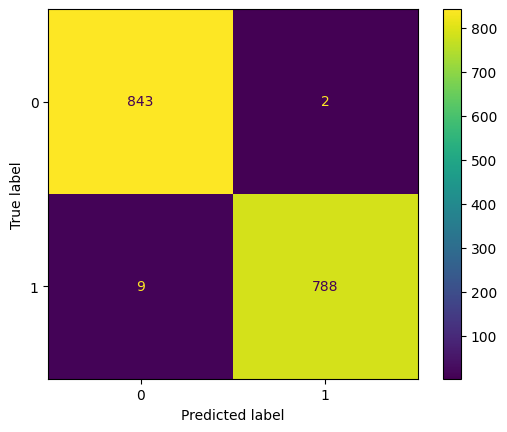

In [47]:
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## RFC Prediction and Evaluation

In [48]:
test_messages = extract_emails_from_mbox("/content/emails-enron-legal-mails.mbox")
test_message_bodies = [extract_content_email(message) for message in test_messages]
# Apply preprocessing function to emails
test_messages_preprocessed = custom_preprocessing(test_message_bodies)
test_messages_corpus = [dictionary.doc2bow(text) for text in test_messages_preprocessed]

In [49]:
all_vector_test = create_vectors_from_messages(test_message_bodies, test_messages_preprocessed,test_messages_corpus)

In [50]:
# RFC Prediction
X = scaler.transform(all_vector_test)
y_pred = rf.predict(X)

num_phishing = 0
for i in y_pred:
  if i == 1:
    num_phishing += 1

print("Number of phishing emails:", num_phishing)
print("Number of benign emails:", len(y_pred) - num_phishing)

Number of phishing emails: 8
Number of benign emails: 4271


In [51]:
email_labels = [0 for i in range(len(y_pred))]
email_accuracy = metrics.accuracy_score(email_labels, y_pred)
print(email_accuracy)

0.9981304043000702


In [ ]:
#test
print(test_message_bodies[100])
print(test_messages_preprocessed[100])

In [ ]:
print("Shape of messages: {}".format(np.array(all_vector_test).shape))

Shape of messages: (4279, 1060)


## SVC - Support Vector Classifier

In [53]:
svc = svm.SVC(gamma="auto")
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [54]:
y_pred = svc.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.976857490864799
Precision: 0.9986859395532195
Recall: 0.9535759096612296


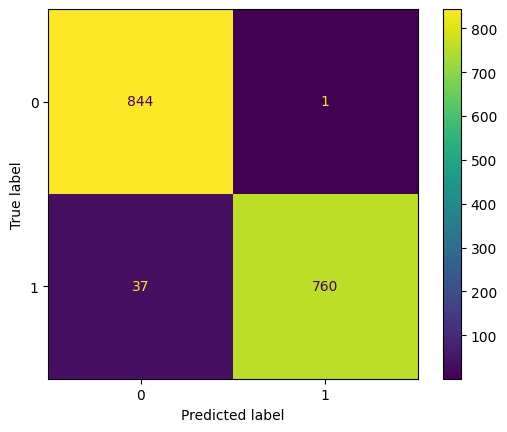

In [55]:
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

##Deep Learning ConvNet (CNN)

From: https://keras.io/examples/nlp/text_classification_from_scratch/

In [56]:
print(tf_config.list_physical_devices('GPU'))
# tf_config.set_visible_devices([], 'GPU')

[]


In [60]:
input_shape = (1, len(X_train[0]), 1) # Batch size is the first number
print(input_shape)

# #Scale data
# X_train = all_vectors
# scaler = sk_preprocessing.StandardScaler()
# scaler.fit(X_train)
#Đã có scaler trong classification
X_train = scaler.transform(all_vectors)

X_train = np.reshape(X_train, (len(X_train), input_shape[1], input_shape[2]))

print(X_train.shape)
y_train = np.reshape(all_labels, (len(X_train), 1))

#Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print(X_train.shape, np.array(y_train).shape, X_test.shape, np.array(y_test).shape)

(1, 1429, 1)
(8207, 1429, 1)
(6565, 1429, 1) (6565, 1) (1642, 1429, 1) (1642, 1)


In [61]:
embedding_dim = 1024
num_layers = 3
inputs = tf_keras.Input(shape=input_shape[1:], dtype = "float32")
x = tf_keras.layers.Conv1D(filters=embedding_dim, kernel_size=2,padding="valid", activation="relu", strides=3)(inputs)
x = tf_keras.layers.Dropout(0.5)(x)
x = tf_keras.layers.Conv1D(filters=embedding_dim, kernel_size=2,padding="valid", activation="relu", strides=3)(x)
x = tf_keras.layers.Dropout(0.5)(x)
x = tf_keras.layers.Conv1D(filters=embedding_dim, kernel_size=2,padding="valid", activation="relu", strides=3)(x)
x = tf_keras.layers.GlobalMaxPooling1D()(x)
x = tf_keras.layers.Dense(embedding_dim, activation="relu")(x)
x = tf_keras.layers.Dropout(0.5)(x)
# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = tf_keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf_keras.Model(inputs, predictions)
# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

In [ ]:
epochs = 128

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/128
206/206 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - binary_accuracy: 0.6878 - loss: 0.5669 - val_binary_accuracy: 0.9361 - val_loss: 0.1771
Epoch 2/128
206/206 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - binary_accuracy: 0.9386 - loss: 0.1846 - val_binary_accuracy: 0.9312 - val_loss: 0.1950
Epoch 3/128
 15/206 ━━━━━━━━━━━━━━━━━━━━ 8:22 3s/step - binary_accuracy: 0.9024 - loss: 0.2334

##CNN Prediction and Evaluation

In [ ]:

X_test = scaler.transform(all_vector_test)
y_pred = model.predict(X_test)

In [ ]:
y_pred_bin = []
num_phishing_CNN = 0
for i in y_pred:
  if i >= 0.5:
    y_pred_bin.append(1)
    num_phishing_CNN += 1
  else:
    y_pred_bin.append(0)

print("Number of phishing emails:", num_phishing_CNN)
print("Number of benign emails:", len(y_pred) - num_phishing_CNN)

In [ ]:
email_accuracy_CNN  = metrics.accuracy_score(email_labels, y_pred_bin)
print(email_accuracy_CNN)

# Experiment Tracking

## Functions: Save stats

In [ ]:
def create_training_stats(num_topics,max_term, X_train, X_test,
                          rfc_accuracy, rfc_recall, email_accuracy,
                          embedding_dim, num_layers, history, email_accuracy_CNN):
  """
  Tạo dictionary chứa số liệu thông kê từ kết quả huấn luyện.
  Parameters:
  - num_topics (int): Số lượng chủ đề.
  - max_term (int): Số lượng từ tối đa trong mô hình TF-IDF.
  - X_train (list): Dữ liệu huấn luyện.
  - X_test (list): Dữ liệu kiểm tra.
  - rfc_accuracy (float): Độ chính xác của mô hình RFC.
  - rfc_recall (float): Độ hồi phục của mô hình RFC.
  - email_accuracy (float): Độ chính xác của mô hình trên GMail (RFC).
  - embedding_dim (int): Kích thước không gian nhúng của mô hình CNN.
  - num_layers (int): Số lượng lớp trong mô hình CNN.
  - history (History): Lịch sử huấn luyện của mô hình CNN.
  - email_accuracy_CNN (float): Độ chính xác của mô hình CNN trên GMail.

  Returns: dictionary chứa dữ liệu thống kê.
  """
  stats_data ={
      "Num Topics" : [num_topics],
      "TF-IDF Count": [max_term],
      "Num Training" : [len(X_train)],
      "Num Test" : [len(X_test)],
      "RFC Test Accuracy" : [rfc_accuracy],
      "RFC Test Recall" : [rfc_recall],
      "RFC GMail Accuracy" : [email_accuracy],
      "CNN Dim" : [embedding_dim],
      "CNN Num Layers" : [num_layers],
      "CNN Accuracy" : [history.history["binary_accuracy"][-1]],
      "CNN Validation Accuracy" : [history.history["val_binary_accuracy"][-1]],
      "CNN GMail Accuracy" : [email_accuracy_CNN]
      }
  return stats_data


def save_stats(stats_data, stats_file_name='stats_results.csv'):
  """
  Lưu số liệu thống kê vào file CSV.

  Parameters:
  - stats (dict): Một dictionary chứa các kết quả cần lưu, ví dụ: {"accuracy": [0.95], "loss": [0.1]}.
  - file_name (str): Tên file CSV nơi lưu kết quả. Mặc định là 'stats_results.csv'.

  Returns: None
  """
  data_frame = pd.DataFrame(stats_data)

  if os.path.isfile(stats_file_name):
    data_frame.to_csv(stats_file_name, mode='a', header=False, index=False)
  else:
    data_frame.to_csv(stats_file_name, mode='w', header=True, index=False)

  print(f"Stats saved to {stats_file_name}")


## Process: Save stats from results

In [ ]:
stats_data = create_training_stats(numTopics, max_term,
                                   X_train, X_test, rfc_accuracy,
                                   rfc_recall, email_accuracy,
                                   embedding_dim, num_layers,
                                   history, email_accuracy_CNN)
print(stats_data)

In [ ]:
stats_file_name = "/results/stats_results.csv"
save_stats(stats_data, stats_file_name)